In [43]:
!pip install -q -r requirements.txt

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
          exec(compile('''
          ~~~~^^^^^^^^^^^^
          # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ...<32 lines>...
          exec(compile(setup_py_code, filename, "exec"))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ''' % ('C:\\Users\\WW\\AppData\\Local\\Temp\\pip-install-2x5p7lnc\\htmlmin_5424f541459d4f35af52e5d93bb6b586\\setup.py',), "<pip-setuptools-caller>", "exec"))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "<pip-setuptools-caller>", line 35, in <module>
        Fi

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

### Loading and Exploring Data

In [46]:
df = pd.read_csv('data/processed/ChurnModelling_Binning_Applied.csv')
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,42.00,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,42.00,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,38.91,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0,Excellent


### Build Scikit-learn Pipelines

**Purpose of building a Scikit-learn pipeline:**

- To automate and streamline the process of data preprocessing and modeling.
- To ensure that all data transformation steps (such as imputation, encoding, and scaling) are applied consistently and in the correct order.
- To make the workflow more reproducible and less error-prone.
- To simplify experimentation by allowing easy swapping or modification of steps.
- To enable integration of preprocessing and modeling into a single object for cross-validation and deployment.

In [47]:
remainder_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
numerical_features=['Age','Tenure', 'Balance', 'EstimatedSalary']
nominal_features=['Geography', 'Gender']
ordinal_features=['CreditScoreBins']

numerical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())        
        ]
)

nominal_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder())        
        ]
)

ordinal_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OrdinalEncoder())        
        ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer,ordinal_features)
    ],
    remainder='drop'  # Drop the remainder features
)

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{value}" for value in unique_values])

df_cp = df.copy()

df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cp),
    columns = numerical_features + nominal_feature_names + ordinal_features
    )


df_pp = pd.concat([df_transformed, df[remainder_features]], axis=1)

df_pp

,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male,CreditScoreBins,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,0.302983,-1.041760,-1.225848,0.021886,1.0,0.0,0.0,1.0,0.0,1.0,1,1,1,1
1,0.204867,-1.387538,0.117350,0.216534,0.0,0.0,1.0,1.0,0.0,1.0,1,0,1,0
2,0.302983,1.032908,1.333053,0.240687,1.0,0.0,0.0,1.0,0.0,3.0,3,1,0,1
3,-0.000196,-1.387538,-1.225848,-0.108918,1.0,0.0,0.0,1.0,0.0,2.0,2,0,0,0
4,0.401100,-1.041760,0.785728,-0.365276,0.0,0.0,1.0,1.0,0.0,0.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.008634,-0.004426,-1.225848,-0.066419,1.0,0.0,0.0,0.0,1.0,4.0,2,1,0,0
9996,-0.383831,1.724464,-0.306379,0.027988,1.0,0.0,0.0,0.0,1.0,3.0,1,1,1,0
9997,-0.285715,0.687130,-1.225848,-1.008643,1.0,0.0,0.0,1.0,0.0,2.0,1,0,1,1
9998,0.302983,-0.695982,-0.022608,-0.125231,0.0,1.0,0.0,0.0,1.0,4.0,2,1,0,1


In [48]:
df_pp.to_csv('data/processed/X_Transformed.csv', index=False)

### Handle Class Imbalance

In [49]:
X = df_pp.drop(columns=['Exited'])
y = df_pp['Exited']

- Churn - 1000
- Non-churn - 9000

- Upsample (churn) = 1000 -> 9000
- Downsample (Non-churn) = 9000 -> 1000

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [51]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Text(0, 0.5, 'Count')

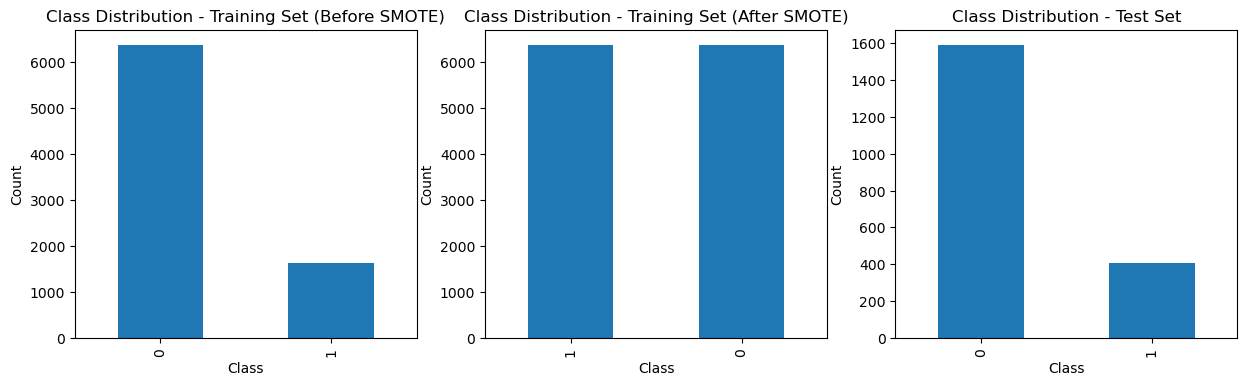

In [53]:
plt.figure(figsize=(15, 4))

# Before SMOTE
plt.subplot(131)
y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

In [54]:
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/y_train.npz', y_train_resampled)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/y_test.npz', y_test)